## 1. Project Overview and Imports

In [47]:
# Import necessary libraries
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
import warnings
import string
warnings.filterwarnings("ignore")

## 2. Load and Explore the Dataset

Dataset Shape:  (6335, 4)
First few rows of the dataset:
    Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  

Label distribution:
 label
REAL    3171
FAKE    3164
Name: count, dtype: int64


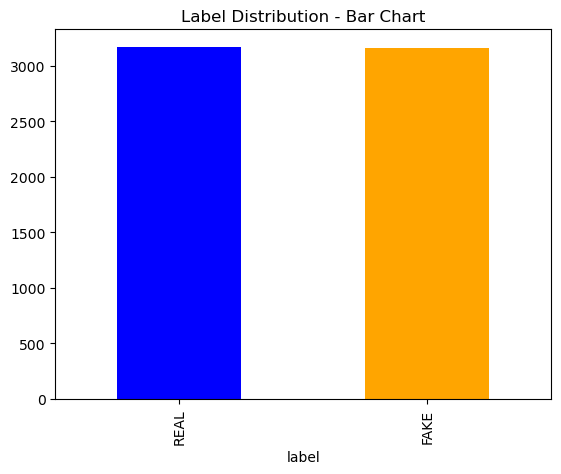

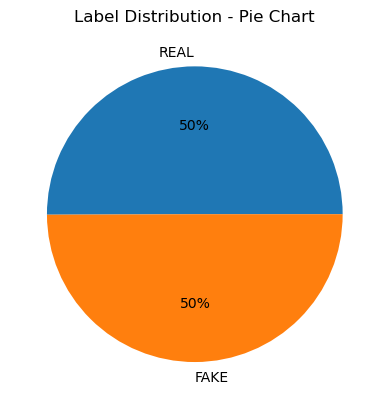

In [48]:
# Load dataset
df = pd.read_csv('content/news.csv')

# Display basic information
print("Dataset Shape: ", df.shape)
print("First few rows of the dataset:\n", df.head())

# Distribution of the target variable
count_class = pd.value_counts(df['label'], sort=True)
print("\nLabel distribution:\n", count_class)

# Plot label distribution (Bar and Pie chart)
count_class.plot(kind='bar', color=["blue", "orange"])
plt.title('Label Distribution - Bar Chart')
plt.show()

count_class.plot(kind='pie', autopct='%1.0f%%')
plt.title('Label Distribution - Pie Chart')
plt.ylabel('')
plt.show()

## 3. Word Frequency Analysis

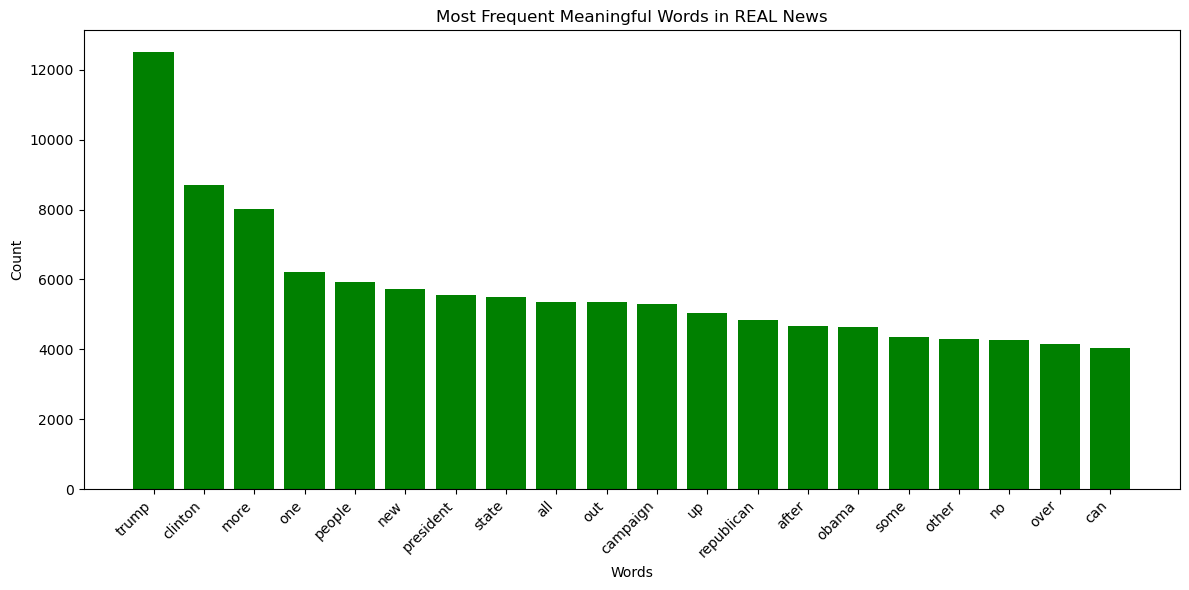

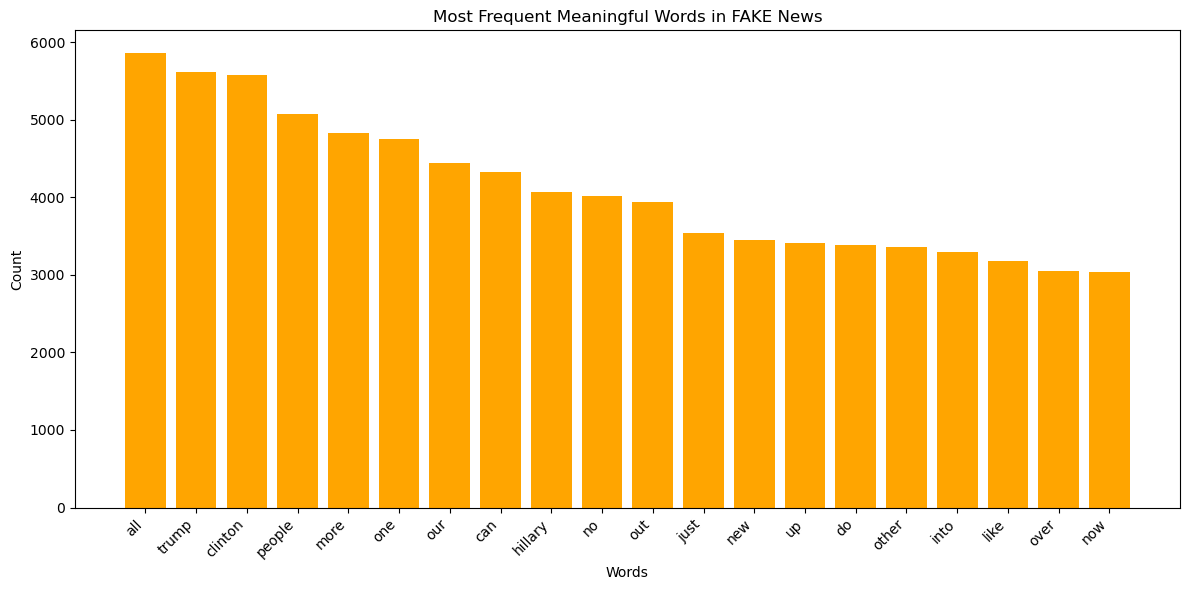

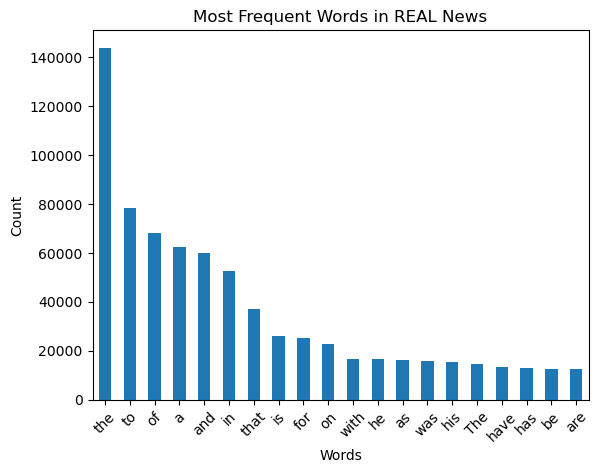

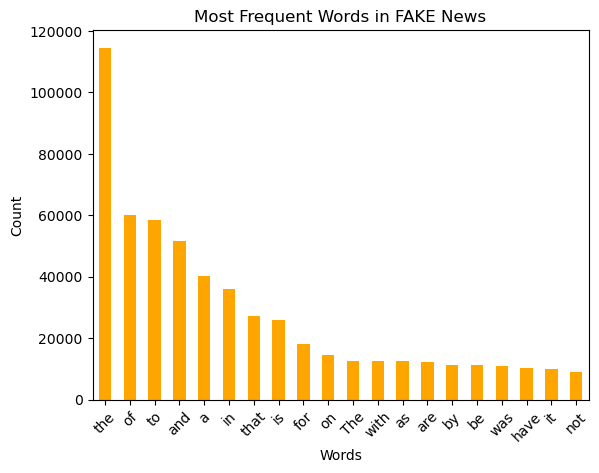

In [49]:
# Define your list of unwanted words
unwanted_words = [
    "the", "to", "of", "a", "and", "in", "that", "is", "for", "on", "he", "as", "with", "said",
    "it", "his", "was", "have", "but", "at", "has", "be", "are", "not", "by", "this", "from", "who", 
    "an", "they", "about", "i", "will", "would", "or", "we", "their", "her", "she", "were",
    "been", "had", "it's", "if", "you", "us", "what", "its", "than", "when", "also", "which",
    "so", "there", "him", "your"
]

def preprocess_text_manual(text, unwanted_words):
    """
    Preprocesses the input text by:
    - Converting to lowercase
    - Removing punctuation
    - Splitting into words based on whitespace
    - Removing manually specified unwanted words
    - Keeping only alphabetic words
    """
    if not isinstance(text, str):
        # Handle cases where the text might not be a string
        return []
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # Split text into words based on whitespace
    words = text.split()
    
    # Remove unwanted words and non-alphabetic words
    meaningful_words = [
        word for word in words 
        if word not in unwanted_words and word.isalpha()
    ]
    
    return meaningful_words

# Apply the preprocessing function to the 'text' column
df['processed_text'] = df['text'].apply(lambda x: preprocess_text_manual(x, unwanted_words))

# Function to get the most common words for a given label
def get_most_common_words(df, label, top_n=20):
    """
    Returns the most common words for a given label.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - label: The label to filter by ('REAL' or 'FAKE')
    - top_n: Number of top common words to return
    
    Returns:
    - List of tuples containing word and its count
    """
    # Filter the DataFrame by label
    filtered_text = df[df['label'] == label]['processed_text']
    
    # Flatten the list of lists into a single list of words
    all_words = list(itertools.chain.from_iterable(filtered_text))
    
    # Count word frequencies
    word_counts = Counter(all_words).most_common(top_n)
    
    return word_counts

# Get the most common words for REAL and FAKE news
count_real = get_most_common_words(df, 'REAL', top_n=20)
count_fake = get_most_common_words(df, 'FAKE', top_n=20)

# Convert word counts to DataFrame
df_real = pd.DataFrame(count_real, columns=["words in REAL", "count"])
df_fake = pd.DataFrame(count_fake, columns=["words in FAKE", "count"])

# Plot word frequencies for REAL news
plt.figure(figsize=(12, 6))
plt.bar(df_real["words in REAL"], df_real["count"], color='green')
plt.xticks(rotation=45, ha='right')
plt.title('Most Frequent Meaningful Words in REAL News')
plt.xlabel('Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot word frequencies for FAKE news
plt.figure(figsize=(12, 6))
plt.bar(df_fake["words in FAKE"], df_fake["count"], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Most Frequent Meaningful Words in FAKE News')
plt.xlabel('Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Frequent words in REAL and FAKE news
count_real = Counter(" ".join(df[df['label'] == 'REAL']["text"]).split()).most_common(20)
count_fake = Counter(" ".join(df[df['label'] == 'FAKE']["text"]).split()).most_common(20)

# Convert word counts to DataFrame
df_real = pd.DataFrame.from_dict(count_real).rename(columns={0: "words in REAL", 1: "count"})
df_fake = pd.DataFrame.from_dict(count_fake).rename(columns={0: "words in FAKE", 1: "count"})

# Plot word frequencies for REAL news
df_real.plot.bar(legend=False)
plt.xticks(np.arange(len(df_real["words in REAL"])), df_real["words in REAL"], rotation=45)
plt.title('Most Frequent Words in REAL News')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()

# Plot word frequencies for FAKE news
df_fake.plot.bar(legend=False, color='orange')
plt.xticks(np.arange(len(df_fake["words in FAKE"])), df_fake["words in FAKE"], rotation=45)
plt.title('Most Frequent Words in FAKE News')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()

## 4. Preprocess Data and Split Dataset

In [50]:
# Define features (X) and target (y)
X = df['text']
y = df['label']

# Split data into training and testing sets (33% test size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Print the size of each split
print(f"Training data size: {X_train.shape[0]}, Testing data size: {X_test.shape[0]}")

Training data size: 4244, Testing data size: 2091


## 5. TF-IDF Vectorization and Model Training

In [51]:
# Define the TF-IDF Vectorizer and LinearSVC Classifier in a pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)),
    ('clf', LinearSVC())
])

# Train the model on training data
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.7, stop_words='english')),
                ('clf', LinearSVC())])

## 6. Evaluate the Model

In [52]:
# Make predictions on the test set
y_pred = text_clf.predict(X_test)

# Calculate and display evaluation metrics
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Confusion Matrix:
 [[1019   52]
 [  77  943]]

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.93      0.95      0.94      1071
        REAL       0.95      0.92      0.94      1020

    accuracy                           0.94      2091
   macro avg       0.94      0.94      0.94      2091
weighted avg       0.94      0.94      0.94      2091

Accuracy: 93.83%


## 7. Implement Multiple Classifiers


Summary of Classifier Performance:
                     Accuracy  Precision     Recall   F1-Score
LinearSVC           93.256815  93.290066  93.256815  93.252888
LogisticRegression  91.439503  91.535954  91.439503  91.428684
MultinomialNB       81.539933  85.567404  81.539933  81.094572
SGDClassifier       93.448111  93.469182  93.448111  93.445260


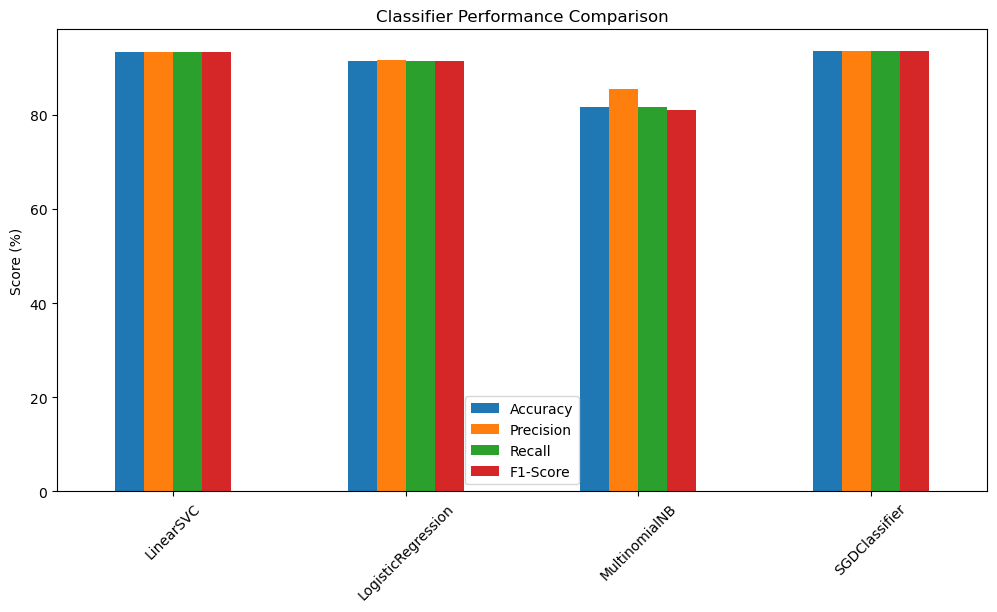

In [53]:
# Define a list of classifiers to compare, including Naive Bayes and SGDClassifier
classifiers = {
    'LinearSVC': LinearSVC(C=100,tol=0.1),
    'LogisticRegression': LogisticRegression(max_iter=100),
    'MultinomialNB': MultinomialNB(),
    'SGDClassifier': SGDClassifier(max_iter=1000, tol=1e-3)
}

# Create an empty dictionary to store results
results = {}

# Loop through each classifier, train, predict, and store the results
for name, clf in classifiers.items():
    # Create a pipeline with TF-IDF and classifier
    pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)), ('clf', clf)])

    # Train the model
    pipe.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipe.predict(X_test)

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Store results in the dictionary
    results[name] = {
        'Accuracy': accuracy * 100,
        'Precision': precision * 100,
        'Recall': recall * 100,
        'F1-Score': f1 * 100
    }

# Convert results to DataFrame for easy display
results_df = pd.DataFrame(results).T
print("\nSummary of Classifier Performance:")
print(results_df)

# Plot results to compare
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Classifier Performance Comparison')
plt.ylabel('Score (%)')
plt.xticks(rotation=45)
plt.show()

## 8. Testing Custom Inputs using SGD Classifier

In [54]:
# Initialize the SGD pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

# Train the pipeline on your training data
text_clf.fit(X_train, y_train)

# Custom predictions to test the model
test_cases = [
    "your email was selected to claim the sum of $5,000,000 in the lottery",
    "India's Covid-19 caseload has crossed the 8.5 lakh mark...",
    "Breaking news: BSF personnel arrested in drug smuggling case",
    "U.S. Secretary of State John F. Kerry said Mon...",
    "It's primary day in New York and front-runners...",
    "Daniel Greenfield, a Shillman Journalism Fello..."
]

# Predict the label for each case using the trained model
for case in test_cases:
    prediction = text_clf.predict([case])
    print(f"Prediction for: \"{case[:50]}...\" is {prediction[0]}")


Prediction for: "your email was selected to claim the sum of $5,000..." is FAKE
Prediction for: "India's Covid-19 caseload has crossed the 8.5 lakh..." is FAKE
Prediction for: "Breaking news: BSF personnel arrested in drug smug..." is FAKE
Prediction for: "U.S. Secretary of State John F. Kerry said Mon......" is REAL
Prediction for: "It's primary day in New York and front-runners......" is REAL
Prediction for: "Daniel Greenfield, a Shillman Journalism Fello......" is FAKE


# 9. Summarize the Results of Different Classifiers


In [55]:
# Identify and print the classifier with the best accuracy
best_classifier = results_df['Accuracy'].idxmax()
best_accuracy = results_df['Accuracy'].max()

print(f"\nThe classifier with the best accuracy is {best_classifier} with an accuracy of {best_accuracy:.2f}%.")

# Discussion on the best classifier
if best_classifier == 'SGDClassifier':
    print(f"\nThe {best_classifier} achieves the highest accuracy at {best_accuracy:.2f}%, which shows that the SGDClassifier performs better than other classifiers for this fake news detection task.")
    print("SGD is known for being efficient with large datasets and converging faster, which likely contributes to its success in this case.")


The classifier with the best accuracy is SGDClassifier with an accuracy of 93.45%.

The SGDClassifier achieves the highest accuracy at 93.45%, which shows that the SGDClassifier performs better than other classifiers for this fake news detection task.
SGD is known for being efficient with large datasets and converging faster, which likely contributes to its success in this case.


In [56]:
# Discuss the performance of each classifier
for name, metrics in results.items():
    print(f"\nClassifier: {name}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}%")
    print(f"Precision: {metrics['Precision']:.2f}%")
    print(f"Recall: {metrics['Recall']:.2f}%")
    print(f"F1-Score: {metrics['F1-Score']:.2f}%")

# Highlight the superior performance of SGDClassifier
print(f"\nSGDClassifier gives the best accuracy of {best_accuracy:.2f}%.")
print(f"SGDClassifier performs well because it uses stochastic gradient descent, which is particularly effective for large-scale and sparse datasets, common in text classification tasks like fake news detection.")


Classifier: LinearSVC
Accuracy: 93.26%
Precision: 93.29%
Recall: 93.26%
F1-Score: 93.25%

Classifier: LogisticRegression
Accuracy: 91.44%
Precision: 91.54%
Recall: 91.44%
F1-Score: 91.43%

Classifier: MultinomialNB
Accuracy: 81.54%
Precision: 85.57%
Recall: 81.54%
F1-Score: 81.09%

Classifier: SGDClassifier
Accuracy: 93.45%
Precision: 93.47%
Recall: 93.45%
F1-Score: 93.45%

SGDClassifier gives the best accuracy of 93.45%.
SGDClassifier performs well because it uses stochastic gradient descent, which is particularly effective for large-scale and sparse datasets, common in text classification tasks like fake news detection.


## 10. Report and Visualize Results

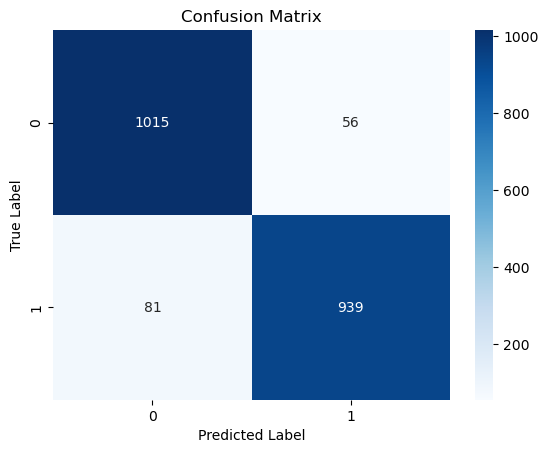

In [57]:
# Save confusion matrix as heatmap
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save classification report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("classification_report.csv")

In [58]:
# Discussion on the results

for name, metrics in results.items():
    print(f"\nClassifier: {name}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}%")
    print(f"Precision: {metrics['Precision']:.2f}%")
    print(f"Recall: {metrics['Recall']:.2f}%")
    print(f"F1-Score: {metrics['F1-Score']:.2f}%")

    # Explanation of results
    print(f"\nThe {name} classifier achieves an accuracy of {metrics['Accuracy']:.2f}%, which is an indication of how well the model is performing overall.")
    print(f"Precision of {metrics['Precision']:.2f}% suggests how often the classifier's positive predictions are correct.")
    print(f"Recall of {metrics['Recall']:.2f}% shows how well the classifier captures all relevant positives in the dataset.")
    print(f"Finally, the F1-Score, a weighted average of precision and recall, is {metrics['F1-Score']:.2f}%, balancing both false positives and false negatives.")

    print("\nOverall, these metrics can help decide the most effective model for fake news detection.")


Classifier: LinearSVC
Accuracy: 93.26%
Precision: 93.29%
Recall: 93.26%
F1-Score: 93.25%

The LinearSVC classifier achieves an accuracy of 93.26%, which is an indication of how well the model is performing overall.
Precision of 93.29% suggests how often the classifier's positive predictions are correct.
Recall of 93.26% shows how well the classifier captures all relevant positives in the dataset.
Finally, the F1-Score, a weighted average of precision and recall, is 93.25%, balancing both false positives and false negatives.

Overall, these metrics can help decide the most effective model for fake news detection.

Classifier: LogisticRegression
Accuracy: 91.44%
Precision: 91.54%
Recall: 91.44%
F1-Score: 91.43%

The LogisticRegression classifier achieves an accuracy of 91.44%, which is an indication of how well the model is performing overall.
Precision of 91.54% suggests how often the classifier's positive predictions are correct.
Recall of 91.44% shows how well the classifier captures